---
title: SpatioTemporal Field - T2M - Stationary - Analysis
subject: AEMET T2M
short_title: 2c - Analysis Region
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
numpyro.set_host_device_count(num_devices)

In [2]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
import arviz as az

from st_evt import CANDIDATE_STATIONS
from st_evt.utils import ExperimentPath
from st_evt.viz import (
    plot_scatter_ts,
    plot_histogram,
    plot_density,
    plot_return_level_gevd_manual_unc_multiple,
    plot_periods,
    plot_periods_diff,
    plot_spain
)
from st_evt.extremes import estimate_return_level_gevd, calculate_exceedence_probs
from omegaconf import OmegaConf

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Data

In [3]:
config_file_name = "/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/config/config.json"
config = OmegaConf.load(config_file_name)

config

{'experiment_name': 'walkthrough/ts_t2m_spain/stationary_iid', 'dataset': 'aemet', 'station_id': 'spain-redfeten', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_spain_stationary.yaml', 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr', 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data', 'clean_data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/clean_data.nc', 'mcmc_results_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary

### Data

In [4]:
root_path = Path(config["exp_path"])
clean_data_path = Path(config["clean_data_path"])
covariate_data_path = Path(config["covariate_path"])
results_data_path = Path(config["mcmc_results_path"])


exp_file_config = ExperimentPath(root_dir=root_path)
figures_path = exp_file_config.figures_results_dir
data_path = exp_file_config.data_dir

### MCMC Results

In [5]:

az_ds = az.from_netcdf(results_data_path)
az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

## Model Errors

### Negative Log-Likelihood

In [6]:

az_ds = az.from_netcdf(results_data_path)
idata = az.extract(az_ds, group="log_likelihood", num_samples=4000).median(dim=["sample"]).load()
idata = idata.sortby("gmst")

In [7]:
isub = idata.obs.rename("nll").sum(dim="time")

subfigures_path = figures_path.joinpath("nll")
subfigures_path.mkdir(parents=True, exist_ok=True)

In [8]:

# labels
cbar_label = "ELBO Loss, $\mathcal{L}(\mathcal{D})$"

#### Density

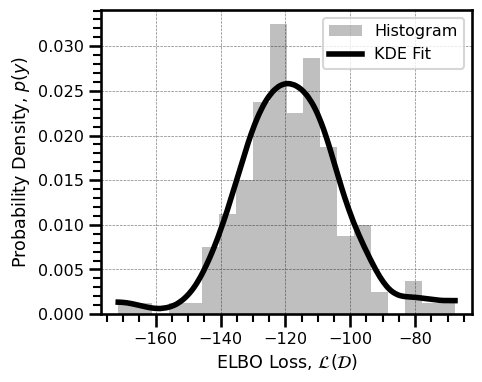

In [9]:
fig, ax = plot_density(isub)
ax.set(
    title="",
    xlabel=cbar_label
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("density.png"))
plt.show()

#### Map

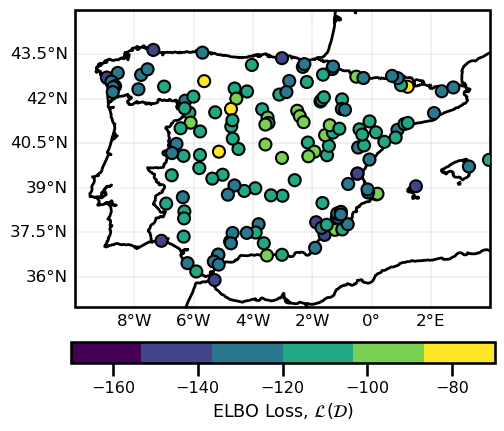

In [10]:
import matplotlib.colors as colors

# colormap
cmap = plt.get_cmap('viridis', 6)
vmin = -170
vmax = -70
norm = colors.Normalize(vmin=vmin, vmax=vmax)


fig, ax, cbar = plot_spain(isub, s=75.0, norm=norm, vmin=vmin, vmax=vmax, cmap=cmap, region="mainland")
cbar.set_label(cbar_label)
fig.set(
    dpi=100,
    size_inches=(10,4)
)
fig.savefig(subfigures_path.joinpath("map.png"))
plt.show()

#### Covariate Regression

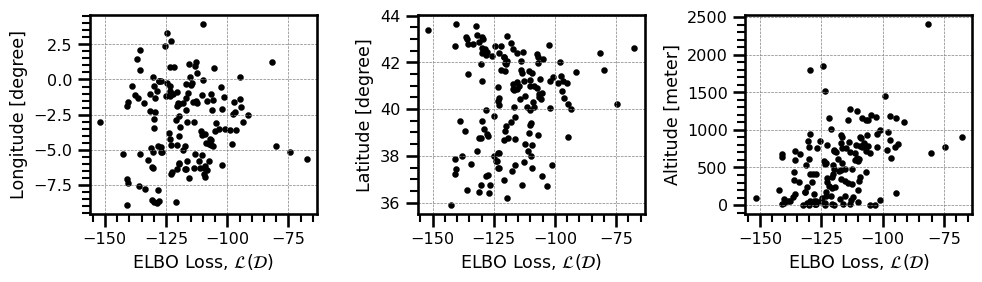

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

# Choose MainLand Only
isub_mainland = isub.where(isub.lon > -10, drop=True )

# LONGITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[0],  x="nll", y="lon", s=10.0, color="black")
ax[0].set(
    xlabel=cbar_label
)
ax[0].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[0].minorticks_on()

# LATITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[1],  x="nll", y="lat", s=10.0, color="black")
ax[1].set(
    xlabel=cbar_label
)
ax[1].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[1].minorticks_on()

# ALTITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[2], x="nll",  y="alt", s=10.0, color="black")
ax[2].set(
    xlabel=cbar_label
)
ax[2].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[2].minorticks_on()
fig.set(
    dpi=100,
    size_inches=(10,3)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("covariates.png"))
plt.show()

## Parameters - Spatial

In [26]:

az_ds = az.from_netcdf(results_data_path)
idata = az.extract(az_ds, group="posterior", num_samples=1000)
idata = idata.sortby("gmst")

### Scale

In [27]:
isub = idata.scale.quantile(q=0.5, dim=["sample"]).squeeze()

subfigures_path = figures_path.joinpath("posterior/scale")
subfigures_path.mkdir(parents=True, exist_ok=True)

In [28]:


# labels
cbar_label = r"Scale, $\boldsymbol{\sigma}_0(\mathbf{s})$ [°C]"

#### Density

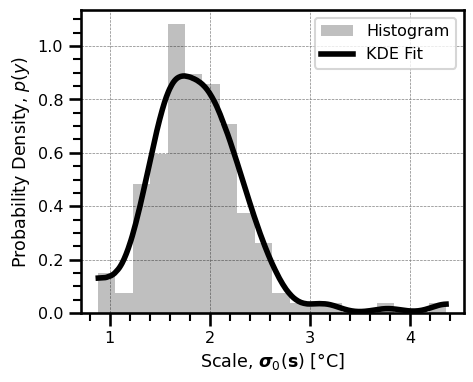

In [29]:
fig, ax = plot_density(isub)
ax.set(
    title="",
    xlabel=cbar_label
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("density.png"))
plt.show()

#### Map

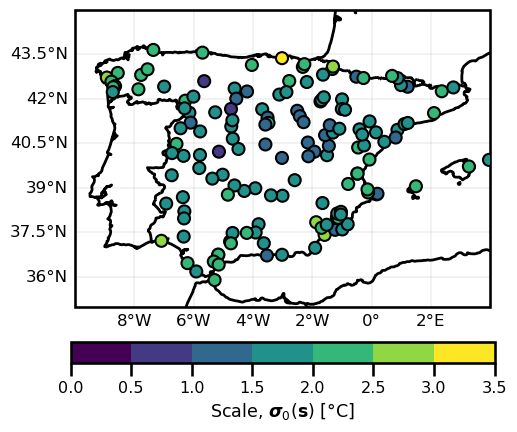

In [30]:
import matplotlib.colors as colors

# colormap
cmap = plt.get_cmap('viridis', 7)
vmin = 0.0
vmax = 3.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax, cbar = plot_spain(isub, norm=norm, vmin=vmin, vmax=vmax, cmap=cmap, s=75.0, region="mainland")
cbar.set_label(cbar_label)
fig.set(
    dpi=100,
    size_inches=(10,4)
)
fig.savefig(subfigures_path.joinpath("map.png"))
plt.show()

#### Covariate Regression

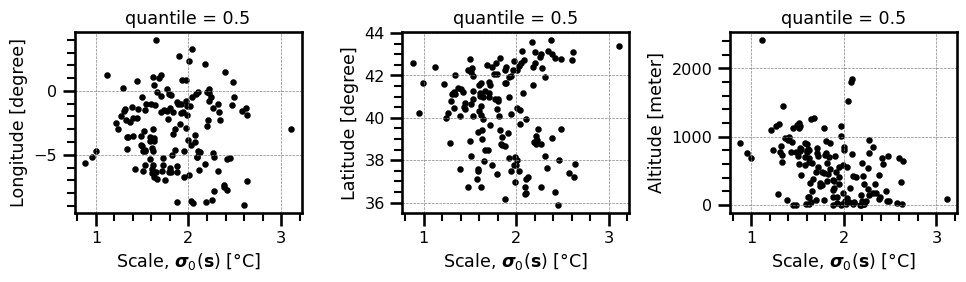

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

# Choose MainLand Only
isub_mainland = isub.where(isub.lon > -10, drop=True ).squeeze()

# LONGITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[0],  x="scale", y="lon", s=10.0, color="black")
ax[0].set(
    xlabel=cbar_label
)
ax[0].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[0].minorticks_on()

# LATITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[1],  x="scale", y="lat", s=10.0, color="black")
ax[1].set(
    xlabel=cbar_label
)
ax[1].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[1].minorticks_on()

# ALTITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[2], x="scale",  y="alt", s=10.0, color="black")
ax[2].set(
    xlabel=cbar_label
)
ax[2].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[2].minorticks_on()
fig.set(
    dpi=100,
    size_inches=(10,3)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("covariates.png"))
plt.show()

### Location

In [43]:
quantile = 0.5
isub = idata.location.quantile(q=quantile, dim=["sample"]).squeeze()

subfigures_path = figures_path.joinpath("location")
subfigures_path.mkdir(parents=True, exist_ok=True)

#### Density

In [44]:

# labels
cbar_label = r"Location Bias, $\boldsymbol{\mu}_1(\mathbf{s})$ [°C]"

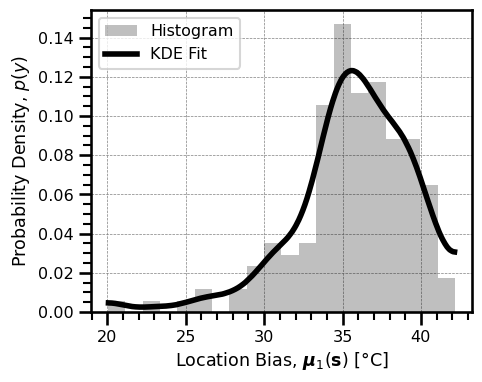

In [45]:
fig, ax = plot_density(isub)
ax.set(
    title="",
    xlabel=cbar_label
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("density.png"))
plt.show()

#### Maps

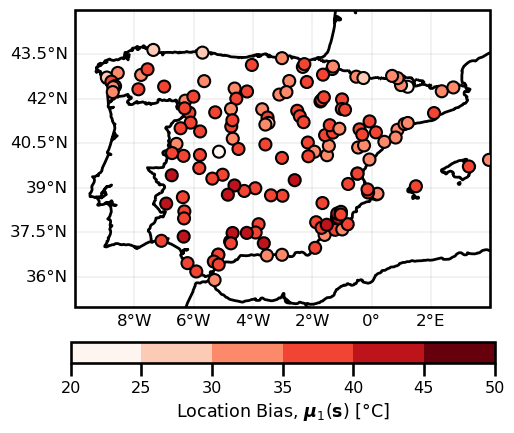

In [46]:
import matplotlib.colors as colors

# colormap
cmap = plt.get_cmap('Reds', 6)
vmin = 20.0
vmax = 50.0
norm = colors.Normalize(vmin=vmin, vmax=vmax)


fig, ax, cbar = plot_spain(isub, norm=norm, vmin=vmin, vmax=vmax, cmap=cmap, s=75.0, region="mainland")
cbar.set_label(cbar_label)
fig.set(
    dpi=100,
    size_inches=(10,4)
)
fig.savefig(subfigures_path.joinpath("map.png"))
plt.show()

#### Covariate Regression

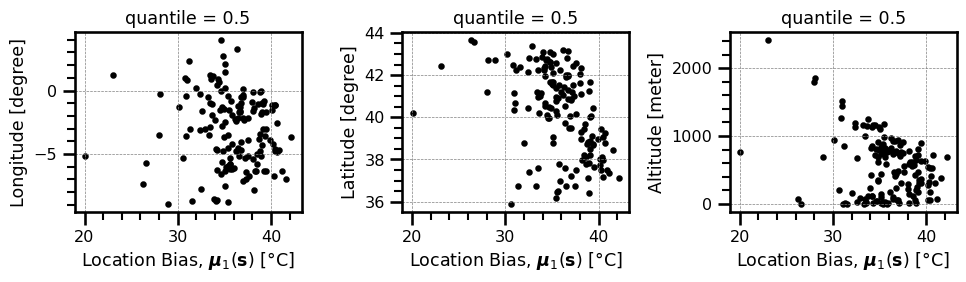

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

# Choose MainLand Only
isub_mainland = isub.where(isub.lon > -10, drop=True )

# LONGITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[0],  x="location", y="lon", s=10.0, color="black")
ax[0].set(
    xlabel=cbar_label
)
ax[0].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[0].minorticks_on()

# LATITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[1],  x="location", y="lat", s=10.0, color="black")
ax[1].set(
    xlabel=cbar_label
)
ax[1].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[1].minorticks_on()

# ALTITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[2], x="location",  y="alt", s=10.0, color="black")
ax[2].set(
    xlabel=cbar_label
)
ax[2].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[2].minorticks_on()
fig.set(
    dpi=100,
    size_inches=(10,3)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("covariates.png"))
plt.show()

### Scale

In [48]:
isub = idata.concentration.quantile(q=0.5, dim=["sample"]).squeeze()

subfigures_path = figures_path.joinpath("posterior/concentration")
subfigures_path.mkdir(parents=True, exist_ok=True)

In [49]:


# labels
cbar_label = r"Concentration, $\boldsymbol{\kappa}_0(\mathbf{s})$ [°C]"

#### Density

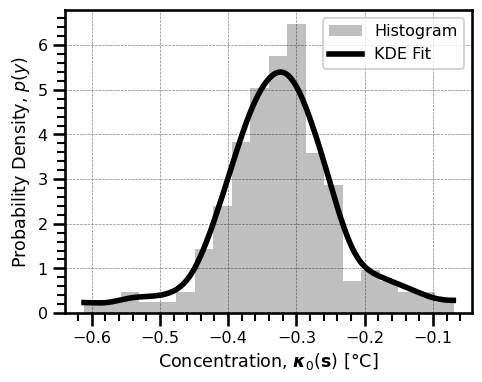

In [50]:
fig, ax = plot_density(isub)
ax.set(
    title="",
    xlabel=cbar_label
)
fig.set(
    dpi=100,
    size_inches=(5,4)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("density.png"))
plt.show()

#### Map

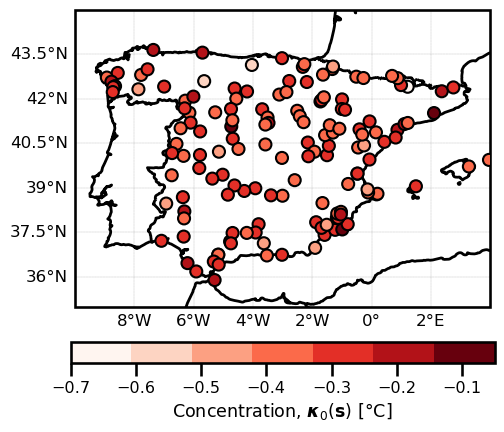

In [51]:
import matplotlib.colors as colors

# colormap
cmap = plt.get_cmap('Reds', 7)
vmin = -0.7
vmax = -0.05
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax, cbar = plot_spain(isub, norm=norm, vmin=vmin, vmax=vmax, cmap=cmap, s=75.0, region="mainland")
cbar.set_label(cbar_label)
fig.set(
    dpi=100,
    size_inches=(10,4)
)
fig.savefig(subfigures_path.joinpath("map.png"))
plt.show()

#### Covariate Regression

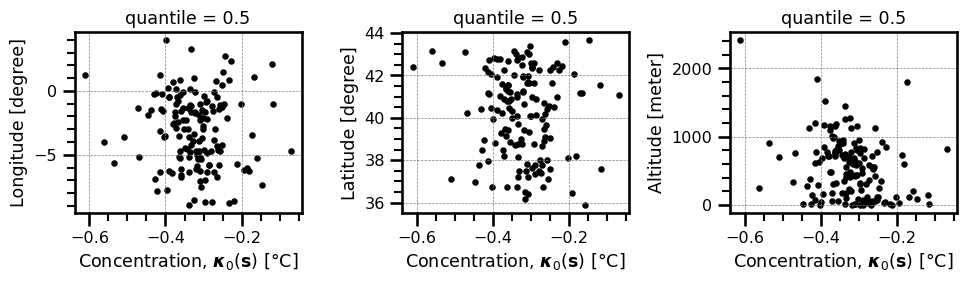

In [52]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

# Choose MainLand Only
isub_mainland = isub.where(isub.lon > -10, drop=True ).squeeze()

# LONGITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[0],  x="concentration", y="lon", s=10.0, color="black")
ax[0].set(
    xlabel=cbar_label
)
ax[0].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[0].minorticks_on()

# LATITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[1],  x="concentration", y="lat", s=10.0, color="black")
ax[1].set(
    xlabel=cbar_label
)
ax[1].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[1].minorticks_on()

# ALTITUDE
isub_mainland.to_dataset().plot.scatter(ax=ax[2], x="concentration",  y="alt", s=10.0, color="black")
ax[2].set(
    xlabel=cbar_label
)
ax[2].grid(True, which="major", linestyle='--', linewidth='0.5', color='gray')
ax[2].minorticks_on()
fig.set(
    dpi=100,
    size_inches=(10,3)
)
plt.tight_layout()
fig.savefig(subfigures_path.joinpath("covariates.png"))
plt.show()